# Model Understanding: Boosted Trees

Objective  
- Interpret Boosted Tress - Locally and Globally
- Gain intuition of boosting on the dataset

Local Interpretability  
- Understanding of a model's prediction at the individual example level
- Create and Visualize per-instance contributions
- Feature importances, Directional Feature Contributions(DFCs)

Global Interpretability  
- Understanding a model in whole, like detect bias and bugs during development.
- Gain based feature importances, Permuation feature importances and aggregated DFCs

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

import tensorflow as tf

train_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

In [3]:
tf.random.set_seed(21)

In [4]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hote_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab)
    )
    
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_df[feature_name].unique()
    feature_columns.append(
        one_hote_cat_column(feature_name, vocabulary)
    )
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

In [5]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if(shuffle):
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(train_df, y_train)
eval_input_fn = make_input_fn(eval_df, y_eval, shuffle=False, n_epochs=1)

### Train the Model
- Enable center_bias to get DFCs
- Center bias will enable the model to predict without features
- Like, mean of training labels for regression or
- Log odds for classification when using cross entropy loss

In [7]:

params = {
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)

results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.862504
auc_precision_recall,0.836979
average_loss,0.424678
label/mean,0.375000
loss,0.424678
precision,0.752688
prediction/mean,0.387535
recall,0.707071


- boosted_trees_classifier_train_in_memory, boosts performance while fitting data in memory
- If training time is not a concern use tf.estimator.BoostedTrees
- Same API can be used for distributed training.

In [8]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1

def make_inmemory_train_input_fn(X, y):
    y = np.expand_dims(y, axis=1)
    def input_fn():
        return dict(X), y
    return input_fn

train_input_fn = make_inmemory_train_input_fn(train_df, y_train)

est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    train_in_memory=True,
    **in_memory_params
)
est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpkca5hzr9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


## Model Interpretation and Plotting
- Directional Feature Contributions(DFCs) to explain individual predictions
- Approach by [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) on [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/)

In [10]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpkca5hzr9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
I

In [11]:
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.023833,0.096798,-0.147963,-0.076392,-0.058287,0.009408,0.562573
sex,264.0,0.007242,0.110388,-0.123509,-0.074560,-0.073093,0.139799,0.182828
class,264.0,0.016344,0.093658,-0.069965,-0.046860,-0.045443,0.038365,0.236259
deck,264.0,-0.016711,0.031673,-0.086021,-0.041980,-0.029283,0.003319,0.187737
embark_town,264.0,-0.006789,0.028007,-0.053620,-0.014970,-0.013391,-0.003095,0.070267
fare,264.0,0.020480,0.087897,-0.308154,-0.028402,-0.008486,0.057093,0.228394
n_siblings_spouses,264.0,0.002527,0.028784,-0.177096,0.002736,0.003991,0.006956,0.135561
parch,264.0,-0.000049,0.009230,-0.075935,0.000389,0.000483,0.000871,0.050035
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### DFCs
Sum of the Contributions + Bias = Prediction Probability  
DFC Plots a single observation

In [13]:
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [14]:
def _get_color(value):
    green, red = sns.color_palette()[2:4]
    if(value >= 0):
        return green
    return red

def _add_feature_values(feature_values, ax):
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue', fontproperties=font, size=12)
    
def plot_example(example):
    TOP_N = 8
    sorted_ix = example.abs().sort_values()[-TOP_N:].index
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(
        kind='barh',
        color=[colors],
        legend=None,
        alpha=0.75,
        figsize=(10, 6)
    )
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)
    
    _add_feature_values(eval_df.iloc[ID][sorted_ix], ax)
    return ax

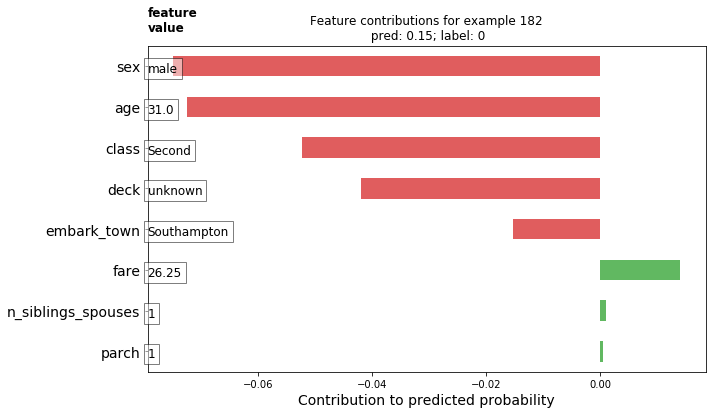

In [15]:
ID = 182
example = df_dfc.iloc[ID]
TOP_N = 8
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [18]:
def dist_violin_plot(df_dfc, ID):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    TOP_N = 8
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')
    
    # Add contributions of entire distribution
    parts = ax.violinplot(
        [df_dfc[w] for w in ix],
        vert=False,
        showextrema=False,
        widths=0.7,
        positions=np.arange(len(ix))
    )
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)
        
    _add_feature_values(eval_df.iloc[ID][sorted_ix], ax)
    
    ax.scatter(
        example,
        np.arange(example.shape[0]),
        color=sns.color_palette()[2],
        s=100,
        marker='s',
        label='Contribution for Example'
    )
    
    ax.plot(
        [0, 0], [1, 1],
        label='eval set contributions\ndistributions',
        color=face_color,
        alpha=alpha,
        linewidth=10
    )
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large', frameon=True)
    
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to Predicted Probability', size=14)

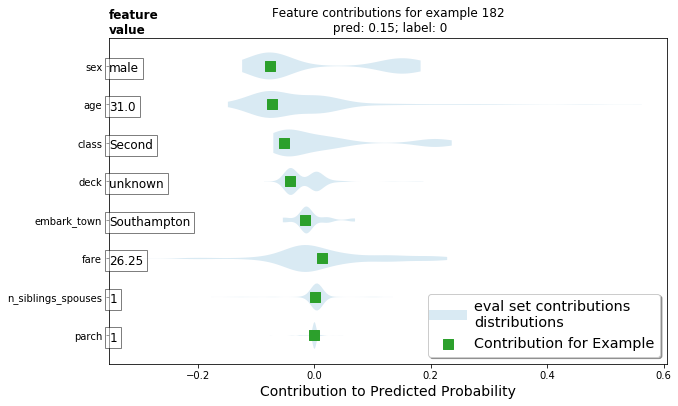

In [19]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

### Global Feature Importance
- Study the model as a whole
- Gain based featue importance using est.experimental_feature_importances
- Permutation importances
- Aggregation of DFCs using est.experimental_predict_with_explanations  

**More Info**  
- Gain Based Feature Importances(GBFI) measure the loss change when splitting on a particular feature
- Permutation Feature Imporatances(PFI) are computed by evaluating model performances on eval set
- PFIs are computed by shuffling each feature and attributing the change in model peformance

- PFIs are preferred over GBFI
- Both are unreliable when 
    - Potential predictor variables vary in their scale of measurement or
    - their number of categories during correlation [Random Forest Importances](https://explained.ai/rf-importance/index.html)
    

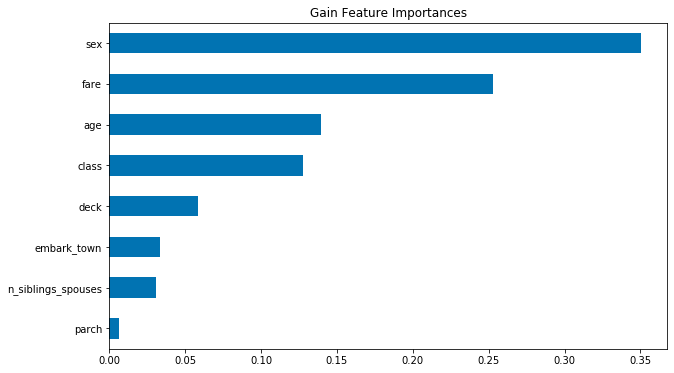

In [20]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

N = 8
ax = (
    df_imp.iloc[0:N][::-1].plot(
        kind='barh',
        color=sns_colors[0],
        title='Gain Feature Importances',
        figsize=(10, 6)
    )
)
ax.grid(False, axis='y')

### Average Absolute DFCs

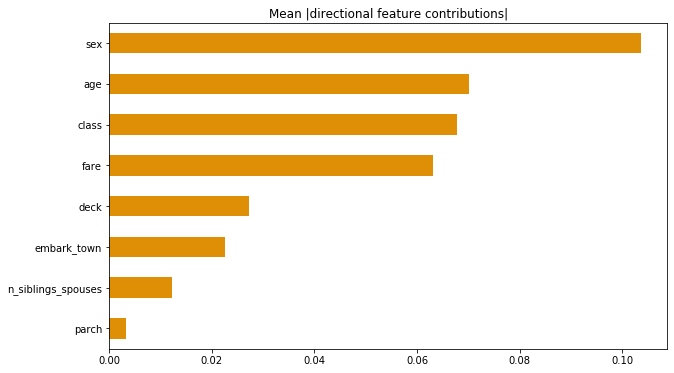

In [21]:
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index
ax = dfc_mean[sorted_ix].plot(
    kind='barh',
    color=sns_colors[1],
    title='Mean |directional feature contributions|',
    figsize=(10, 6)
)
ax.grid(False, axis='y')

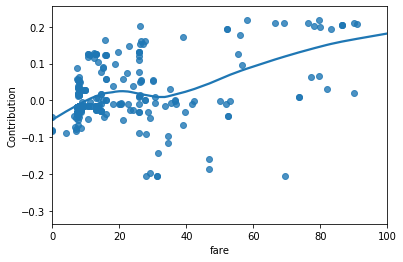

In [22]:
FEATURE = 'fare'
feature = pd.Series(
    df_dfc[FEATURE].values,
    index=eval_df[FEATURE].values
).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('Contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

### Permutation Feature Importance

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-28T00:04:38Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpkca5hzr9/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.69998s
INFO:tensorflow:Finished evaluation at 2020-03-28-00:04:39
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.8030303, accuracy_baseline = 0.625, auc = 0.8679522, auc_precision_recall = 0.85285693, average_loss = 0.4202864, global_step = 153, label/mean = 0.375, loss = 0.4202864, precision = 0.7473684, prediction/mean = 0.38677043, recall = 0.7171717
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpkca5hzr9/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO

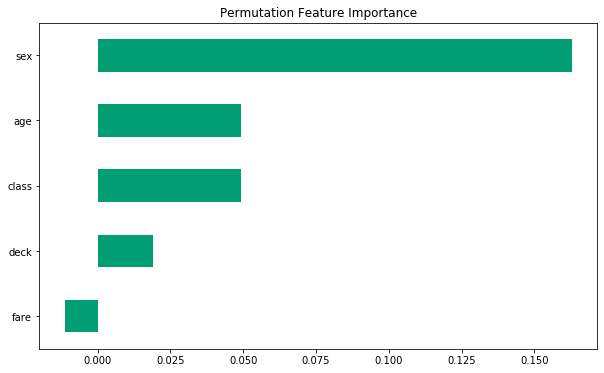

In [24]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    eval_input_fn = make_input_fn(
        X, y=y, shuffle=True, n_epochs=1
    )
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, eval_df, y_eval, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation Feature Importance')
plt.show()

## Visualizing Model Fitting

In [25]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(21)
npts = 5000

x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x * np.exp(-x**2 - y**2)
xy = np.zeros((2, np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [26]:
# Prep data for training
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z
})
xi = np.linspace(-2.0, 2.0, 200)
yi = np.linspace(-2.1, 2.1, 210)
xi, yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x': xi.flatten(),
    'y': yi.flatten()
})
predict_shape = xi.shape

In [27]:
def plot_contour(x, y, z, **kwargs):
    plt.figure(figsize=(10, 8))
    # Contour the gridded data, plotting dots at the nonuniform data points
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x, y, z, 15, vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar()
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

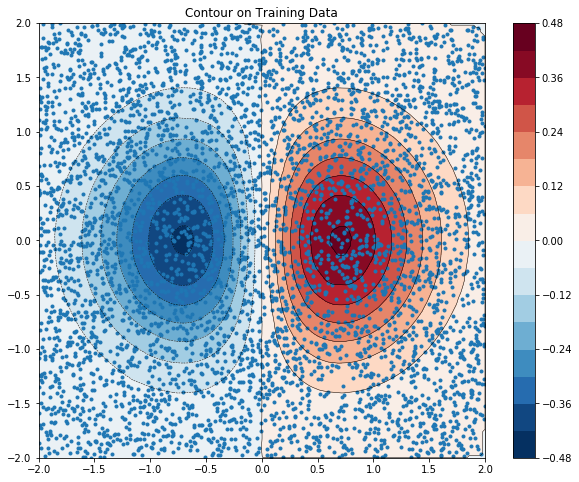

In [29]:
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on Training Data')
plt.show()

In [30]:
fc = [
    tf.feature_column.numeric_column('x'),
    tf.feature_column.numeric_column('y')
]

In [31]:
def predict(est):
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

In [32]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmp30agosz6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in f

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmp30agosz6/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


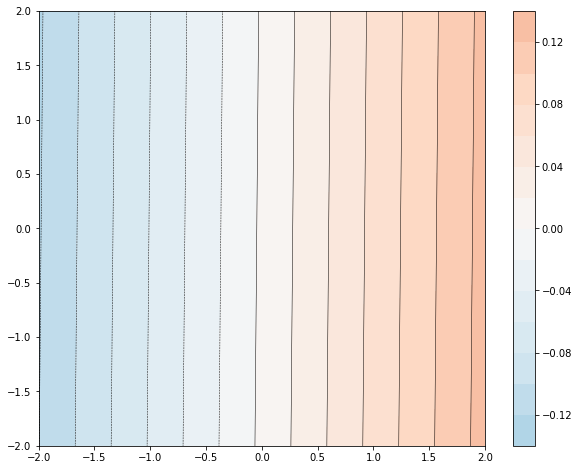

In [33]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpslqo7e73/model.ckpt-192
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


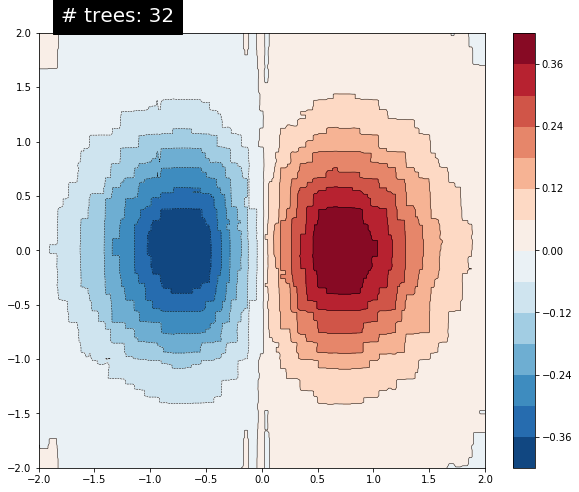

In [34]:
n_trees = 32

est = tf.estimator.BoostedTreesRegressor(
    fc, n_batches_per_layer=1, n_trees=n_trees
)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()